In [1]:
import glob
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

%matplotlib notebook

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
df = pd.read_csv('tps2_level3/tps2_level3_0801_final2.csv')
df['latlon'] = df['latlon'].apply(eval)
df.shape

(1089687, 4)

In [3]:
df.head()

,id,time,latlon,latlon_dp
0,38:9a:f6:09:41:cf,"2019-08-01 12:40:52.54 UTC""}","(-22.81558913509583, -43.245774218502156)","(-22.81558914, -43.24577422)"
1,34:69:87:12:42:b9,"2019-08-01 12:41:02.31 UTC""}","(-22.81496452110543, -43.245020503749934)","(-22.81496452, -43.2450205)"
2,44:91:60:43:04:86,"2019-08-01 12:41:09.102 UTC""}","(-22.8147834585671, -43.244080633180275)","(-22.81478346, -43.24408063)"
3,40:9b:cd:98:da:1c,"2019-08-01 12:41:16.29 UTC""}","(-22.815464419551866, -43.245705881484064)","(-22.81546442, -43.24570588)"
4,30:4b:07:0b:c6:64,"2019-08-01 12:41:34.716 UTC""}","(-22.81455206630036, -43.24709138975604)","(-22.81455207, -43.24709139)"


In [4]:
# df['latlon_dp'] = df.latlon.map(lambda x: (round(x[0],8), round(x[1],8)))
# df.drop_duplicates(['id','latlon_dp'], inplace=True)
# df.shape

In [5]:
vc = df['id'].value_counts()
df.set_index('id', inplace=True)

wrong_id = [i for i in vc.index if vc[i] == 1]
len(wrong_id)

0

In [6]:
df.drop(wrong_id, axis=0, inplace=True)
df.reset_index(inplace=True)
df.shape

(1089687, 4)

In [7]:
df['latlon_rev'] = df['latlon'].apply(lambda x: (x[0]+22.8165, x[1]+43.2479))

coords = np.array(df.latlon_rev.tolist())
kmeans = MiniBatchKMeans(init='k-means++', n_clusters=50,random_state=0, n_init=10).fit(coords)
df['cluster'] = kmeans.predict(coords)

In [8]:
cluster_rank = df.groupby('cluster').count().id.rank(ascending=False).astype(int)
df['cluster'] = df['cluster'].map(lambda x: cluster_rank[x])

center = kmeans.cluster_centers_
z_center = [cluster_rank[i] for i in kmeans.predict(center)]
center_dict = {z_center[i]:center[i] for i in range(len(center))}

In [9]:
h = .000002 
x_min, x_max = (0, 0.004)
y_min, y_max = (0, 0.004)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

In [10]:
# from scipy.spatial import Delaunay

# def alpha_shape(points, alpha, only_outer=True):
#     """
#     Compute the alpha shape (concave hull) of a set of points.
#     :param points: np.array of shape (n,2) points.
#     :param alpha: alpha value.
#     :param only_outer: boolean value to specify if we keep only the outer border
#     or also inner edges.
#     :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
#     the indices in the points array.
#     """
#     assert points.shape[0] > 3, "Need at least four points"

#     def add_edge(edges, i, j):
#         """
#         Add an edge between the i-th and j-th points,
#         if not in the list already
#         """
#         if (i, j) in edges or (j, i) in edges:
#             # already added
#             assert (j, i) in edges, "Can't go twice over same directed edge right?"
#             if only_outer:
#                 # if both neighboring triangles are in shape, it's not a boundary edge
#                 edges.remove((j, i))
#             return
#         edges.add((i, j))

#     tri = Delaunay(points)
#     edges = set()
#     # Loop over triangles:
#     # ia, ib, ic = indices of corner points of the triangle
#     for ia, ib, ic in tri.vertices:
#         pa = points[ia]
#         pb = points[ib]
#         pc = points[ic]
#         # Computing radius of triangle circumcircle
#         # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
#         a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
#         b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
#         c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
#         s = (a + b + c) / 2.0
#         area = np.sqrt(s * (s - a) * (s - b) * (s - c))
#         circum_r = a * b * c / (4.0 * area)
#         if circum_r < alpha:
#             add_edge(edges, ia, ib)
#             add_edge(edges, ib, ic)
#             add_edge(edges, ic, ia)
#     return edges

In [11]:
# edges = alpha_shape(coords, alpha=1, only_outer=True)

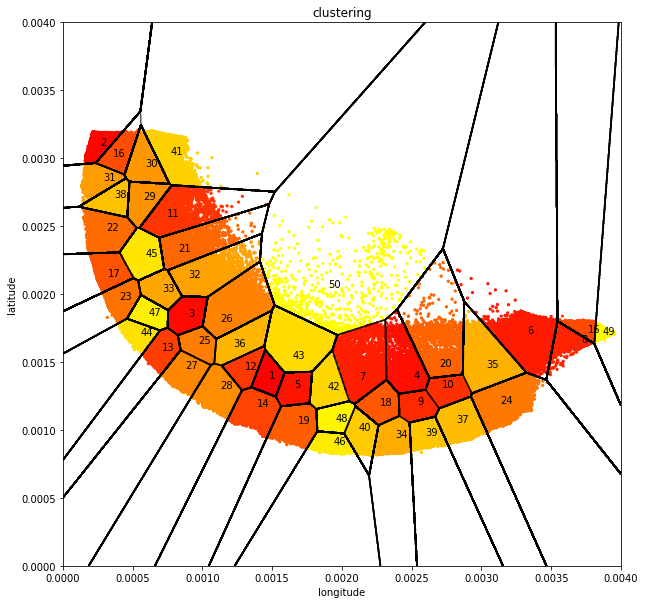

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
ax.contour(yy, xx, Z, 100, alpha=0.4,colors='black')
ax.scatter(coords[:, 1], coords[:, 0],c=df['cluster'].values, cmap='autumn',s=5)
for i in range(len(center)):
    ax.text(center[i][1], center[i][0], int(z_center[i]) , color='black')
# for i, j in edges:
#     ax.plot(coords[[i, j], 1], coords[[i, j], 0], color='black', linewidth=3)
plt.title('clustering')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.show()
# plt.savefig("frame_with_points.png", bbox_inches = 'tight', dpi=100,
#     pad_inches = 0)

In [13]:
# import folium
# from folium.plugins import FastMarkerCluster
# subset_of_df = df.sample(n=3000)
# some_map = folium.Map(location=[subset_of_df['latlon'].map(lambda x: x[0]).mean(), 
#                                 subset_of_df['latlon'].map(lambda x: x[1]).mean()], 
#                       zoom_start=12)

# callback = ('function (row) {' 
#                 'var circle = L.circle(new L.LatLng(row[0], row[1]), {color: "red",  radius: 10});'
#                 'return circle};')

# some_map.add_child(FastMarkerCluster(subset_of_df['latlon'].tolist(), callback=callback))

In [14]:
df.loc[:,'time'] = df.time.map(lambda x: re.sub('\ UTC\"\}', '',x))
df.loc[:,'datetime'] = df.time.map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f') if len(x) >19 else datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df.loc[:,'time'] = df.datetime.map(lambda x: x.time())
df.loc[:, 'hour'] = df.time.map(lambda x: x.hour)

In [15]:
df.loc[:, 'minute'] = df.time.map(lambda x: x.minute)
df['total_minute'] = df['hour'] * 60 + df['minute']
df['total_minute_class'] = (df['total_minute']//5).astype(int)

In [16]:
# import matplotlib.animation
# import imageio
# # from IPython.display import display, clear_output
# def plot_for_offset(h):
#     fig, ax = plt.subplots(figsize=(16, 16))
#     ax.contour(yy, xx, Z, 100, alpha=0.4, colors='black')
#     ax.set_xlim(x_min, x_max)
#     ax.set_ylim(y_min, y_max)
#     for i in range(len(center)):
#         ax.text(center[i][1], center[i][0], z_center[i], color='black')
#     hour = h*5//60
#     minute = h*5 - h*5//60 * 60
#     ax.set_title('{} hour {} minute'.format(hour, minute))
#     temp = df[df.total_minute_class == h]
#     if temp.shape[0] != 0:
#         temp_coord = np.array(temp.latlon_rev.tolist())
#         ax.scatter(temp_coord[:, 1], temp_coord[:, 0],
#                         c=temp['cluster'].values, cmap='autumn', s=5)
#     else:
#         ax.scatter([], [])
    
#     fig.canvas.draw()       # draw the canvas, cache the renderer
#     image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#     image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

#     return image
# #     clear_output(wait=True)
# #     display(fig)
# # clear_output(wait=True)
# kwargs_write = {'fps':1.0, 'quantizer':'nq'}
# imageio.mimsave('./powers.gif', [plot_for_offset(h) for h in range(80,100)], fps=1)

In [17]:
df_gb = df.sort_values('time').groupby('id').agg(list)

In [18]:
def haversine_dist(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h
def dist_list(latlon_list):
    dl = []
    i = 0
    while i < len(latlon_list)-1:
        dist = haversine_dist(latlon_list[i][0], latlon_list[i][1], latlon_list[i+1][0], latlon_list[i+1][1])
        dl.append(dist*1000)
        i += 1
    return dl

df_gb.loc[:,'distance'] = df_gb.latlon.map(dist_list)

In [19]:
def time_period(time_list):
    tl = []
    i = 1
    while i < len(time_list):
        diff = time_list[i]-time_list[i-1]
        tl.append(diff.total_seconds())
        i += 1
    return tl

df_gb.loc[:,'time_diff'] = df_gb.datetime.map(time_period)

In [20]:
def cal_speed(dist_list, time_list):
    return [b / m for b,m in zip(dist_list, time_list)]

df_gb.loc[:,'speed'] = df_gb.apply(lambda x: cal_speed(x.distance, x.time_diff), axis=1)

In [21]:
df_gb.head()

,time,latlon,latlon_dp,latlon_rev,cluster,datetime,hour,minute,total_minute,total_minute_class,distance,time_diff,speed
id,,,,,,,,,,,,,
00:04:e2:81:f5:37,"[07:34:37.789000, 16:34:39.233000]","[(-22.81475888159292, -43.24680708069254), (-2...","[(-22.81475888, -43.24680708), (-22.81468422, ...","[(0.0017411184070823538, 0.0010929193074602495...","[26, 3]","[2019-08-01 07:34:37.789000, 2019-08-01 16:34:...","[7, 16]","[34, 34]","[454, 994]","[90, 198]",[35.45952859868329],[32401.444],[0.0010943811207513867]
00:05:16:59:ad:2b,"[09:40:01.552000, 09:40:11.578000, 09:40:21.55...","[(-22.81528744228324, -43.24607516385258), (-2...","[(-22.81528744, -43.24607516), (-22.81542414, ...","[(0.0012125577167623192, 0.0018248361474206831...","[42, 19, 19, 19, 40, 40, 42, 18, 18, 40, 48, 1...","[2019-08-01 09:40:01.552000, 2019-08-01 09:40:...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ...","[40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 4...","[580, 580, 580, 580, 580, 581, 581, 581, 581, ...","[116, 116, 116, 116, 116, 116, 116, 116, 116, ...","[17.60520481758613, 14.073570260344276, 14.797...","[10.026, 9.981, 10.013, 21.012, 9.994, 9.979, ...","[1.7559549987618324, 1.4100360946141945, 1.477..."
00:05:16:59:bf:81,"[10:12:32.916000, 10:14:45.190000]","[(-22.81429838054123, -43.24725919282879), (-2...","[(-22.81429838, -43.24725919), (-22.81443062, ...","[(0.0022016194587699545, 0.0006408071712087349...","[45, 33]","[2019-08-01 10:12:32.916000, 2019-08-01 10:14:...","[10, 10]","[12, 14]","[612, 614]","[122, 122]",[21.31542230128923],[132.274],[0.16114597200726696]
00:05:16:59:cd:ff,"[16:03:00.991000, 16:04:34.995000, 16:05:35.76...","[(-22.814939029726933, -43.24584312587084), (-...","[(-22.81493903, -43.24584313), (-22.81524264, ...","[(0.0015609702730685626, 0.0020568741291597803...","[7, 28, 14, 14, 28, 28, 12, 14, 14]","[2019-08-01 16:03:00.991000, 2019-08-01 16:04:...","[16, 16, 16, 16, 16, 16, 16, 16, 16]","[3, 4, 5, 6, 7, 8, 9, 10, 11]","[963, 964, 965, 966, 967, 968, 969, 970, 971]","[192, 192, 193, 193, 193, 193, 193, 194, 194]","[95.57362989156901, 21.28206615512593, 6.97311...","[94.004, 60.766, 51.22, 60.812, 51.094, 71.12,...","[1.016697479804785, 0.350229835024947, 0.13614..."
00:05:16:59:e4:bd,"[16:46:50.041000, 16:47:10.913000, 16:50:04.36...","[(-22.814785443342014, -43.24656893667266), (-...","[(-22.81478544, -43.24656894), (-22.81483667, ...","[(0.001714556657987032, 0.001331063327342008),...","[36, 43, 48, 42, 13, 47, 7, 9, 32, 11, 43, 43,...","[2019-08-01 16:46:50.041000, 2019-08-01 16:47:...","[16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 1...","[46, 47, 50, 50, 51, 52, 53, 55, 57, 3, 5, 9, ...","[1006, 1007, 1010, 1010, 1011, 1012, 1013, 101...","[201, 201, 202, 202, 202, 202, 202, 203, 203, ...","[36.18150117688006, 59.78896317067171, 6.04694...","[20.872, 173.455, 39.934, 40.874, 50.79, 81.51...","[1.7334946903449626, 0.3446943770469096, 0.151..."


In [22]:
df_gb_path = df_gb.drop(['time', 'latlon_dp','latlon','hour','minute','total_minute','distance', 'time_diff'], axis=1)

In [23]:
df_gb_path

,latlon_rev,cluster,datetime,total_minute_class,speed
id,,,,,
00:04:e2:81:f5:37,"[(0.0017411184070823538, 0.0010929193074602495...","[26, 3]","[2019-08-01 07:34:37.789000, 2019-08-01 16:34:...","[90, 198]",[0.0010943811207513867]
00:05:16:59:ad:2b,"[(0.0012125577167623192, 0.0018248361474206831...","[42, 19, 19, 19, 40, 40, 42, 18, 18, 40, 48, 1...","[2019-08-01 09:40:01.552000, 2019-08-01 09:40:...","[116, 116, 116, 116, 116, 116, 116, 116, 116, ...","[1.7559549987618324, 1.4100360946141945, 1.477..."
00:05:16:59:bf:81,"[(0.0022016194587699545, 0.0006408071712087349...","[45, 33]","[2019-08-01 10:12:32.916000, 2019-08-01 10:14:...","[122, 122]",[0.16114597200726696]
00:05:16:59:cd:ff,"[(0.0015609702730685626, 0.0020568741291597803...","[7, 28, 14, 14, 28, 28, 12, 14, 14]","[2019-08-01 16:03:00.991000, 2019-08-01 16:04:...","[192, 192, 193, 193, 193, 193, 193, 194, 194]","[1.016697479804785, 0.350229835024947, 0.13614..."
00:05:16:59:e4:bd,"[(0.001714556657987032, 0.001331063327342008),...","[36, 43, 48, 42, 13, 47, 7, 9, 32, 11, 43, 43,...","[2019-08-01 16:46:50.041000, 2019-08-01 16:47:...","[201, 201, 202, 202, 202, 202, 202, 203, 203, ...","[1.7334946903449626, 0.3446943770469096, 0.151..."
...,...,...,...,...,...
fe:f7:e2:a4:c8:d1,"[(0.001693371349283268, 0.003146377342403639),...","[6, 8]","[2019-08-01 19:36:06.134000, 2019-08-01 19:36:...","[235, 235]",[2.08478177048884]
fe:fb:42:47:14:60,"[(0.001510320203522042, 0.001267611840269467),...","[12, 12]","[2019-08-01 16:28:50.266000, 2019-08-01 16:29:...","[197, 197]",[0.9597578898478383]
fe:fc:5b:29:51:08,"[(0.0019981199865419796, 0.0007484791343301822...","[33, 23]","[2019-08-01 08:07:04.290000, 2019-08-01 08:09:...","[97, 97]",[0.17107334858218845]


In [24]:
df_gb_path = df_gb_path.loc['00:3d:e8:b3:11:54',:]

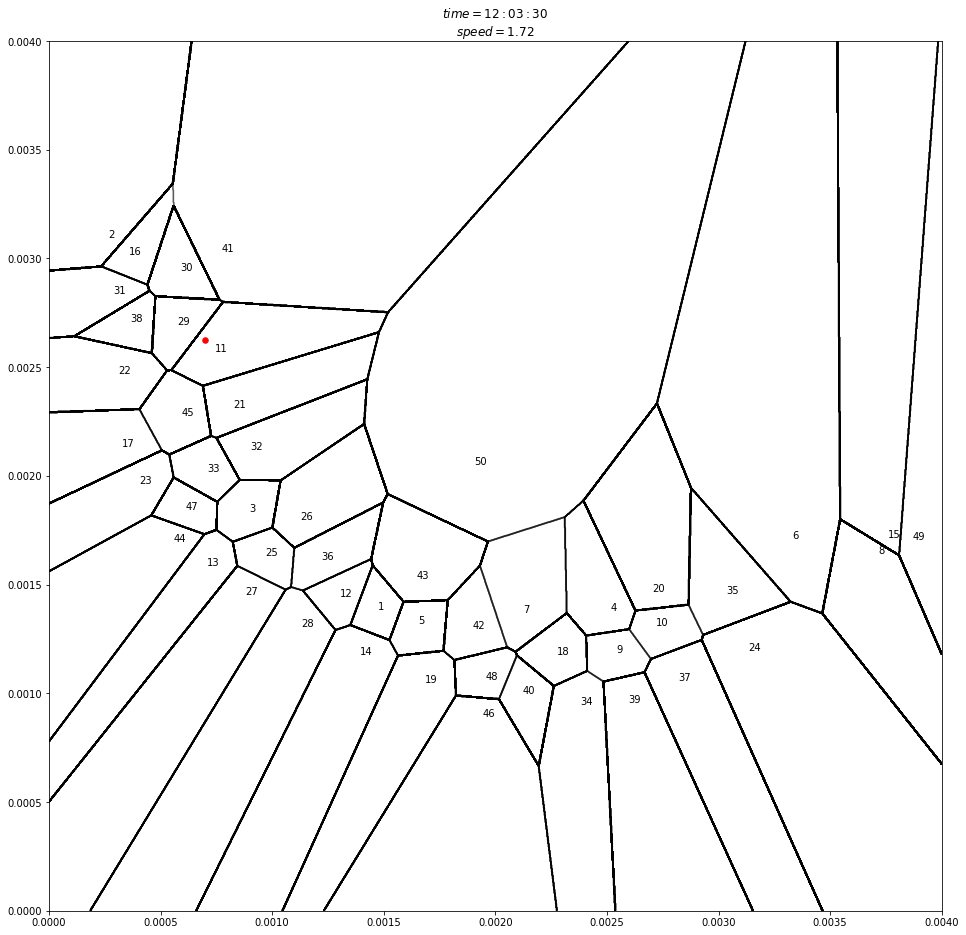

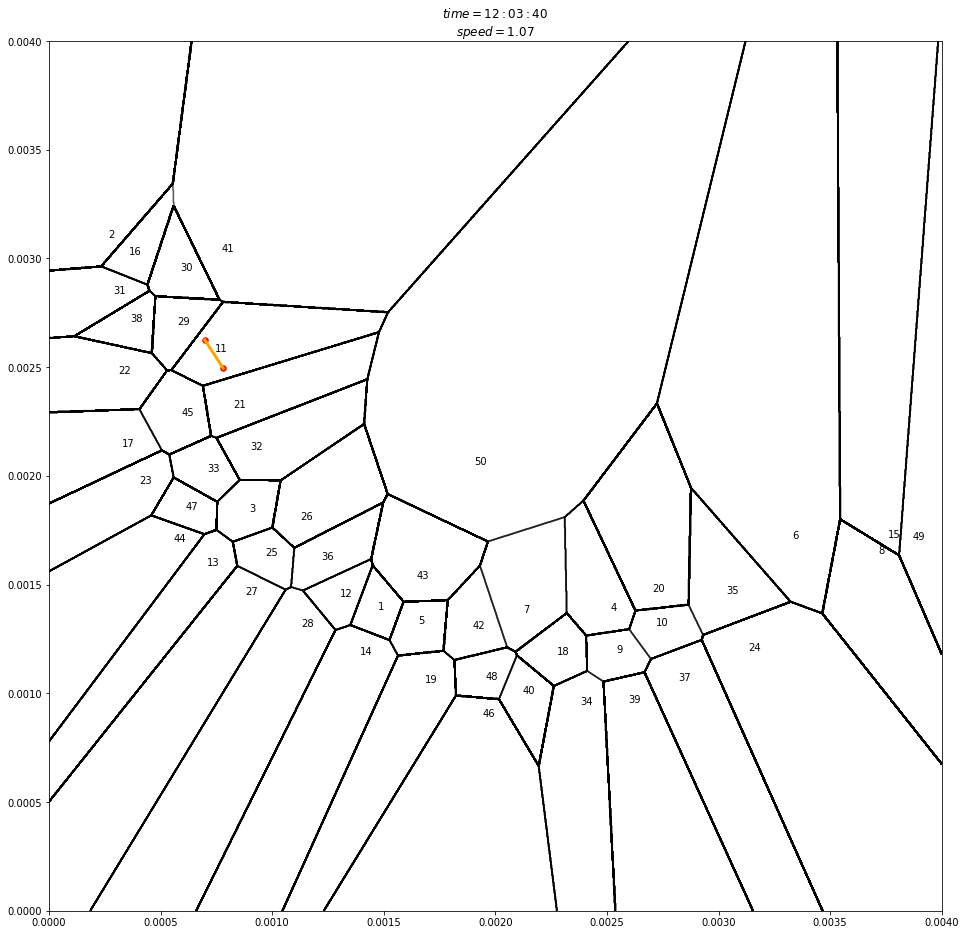

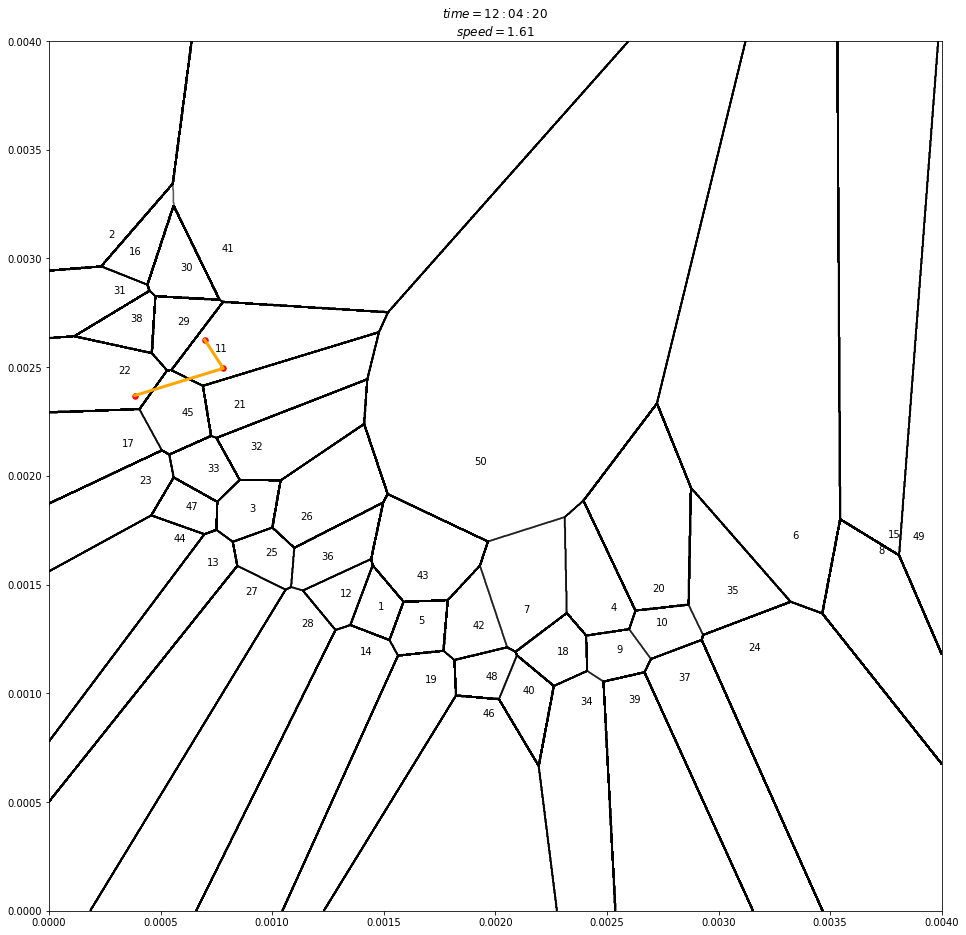

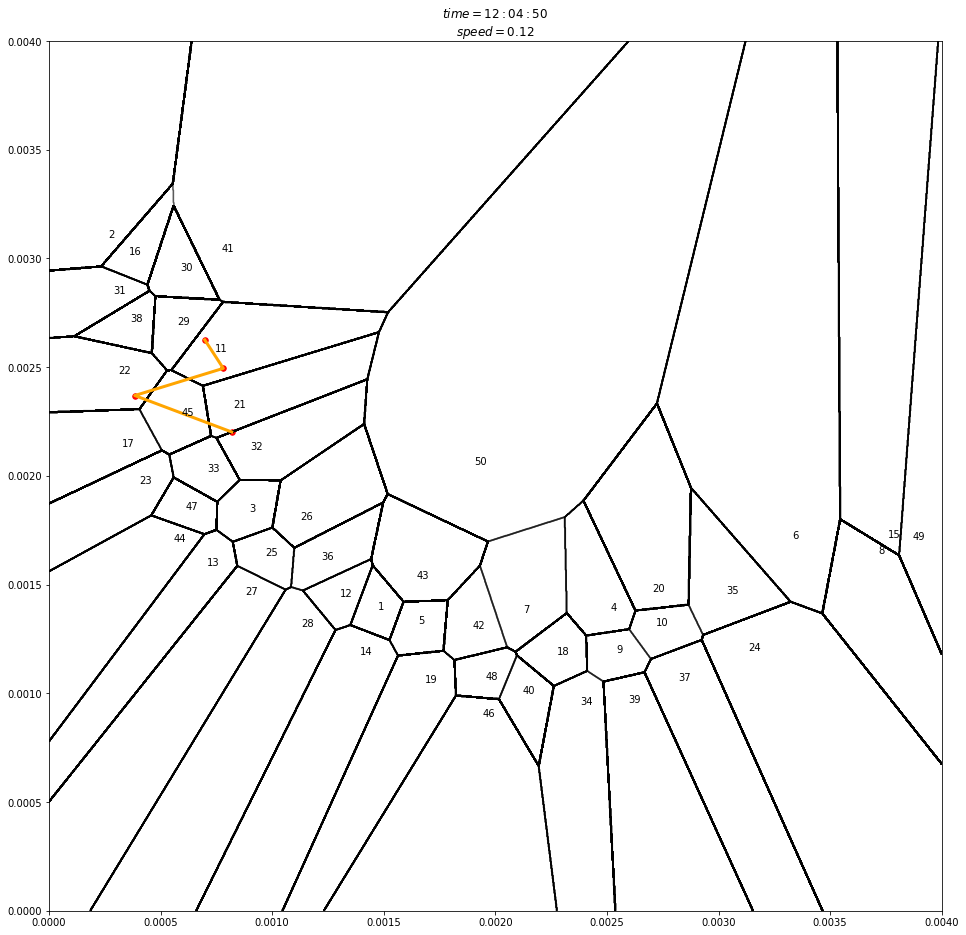

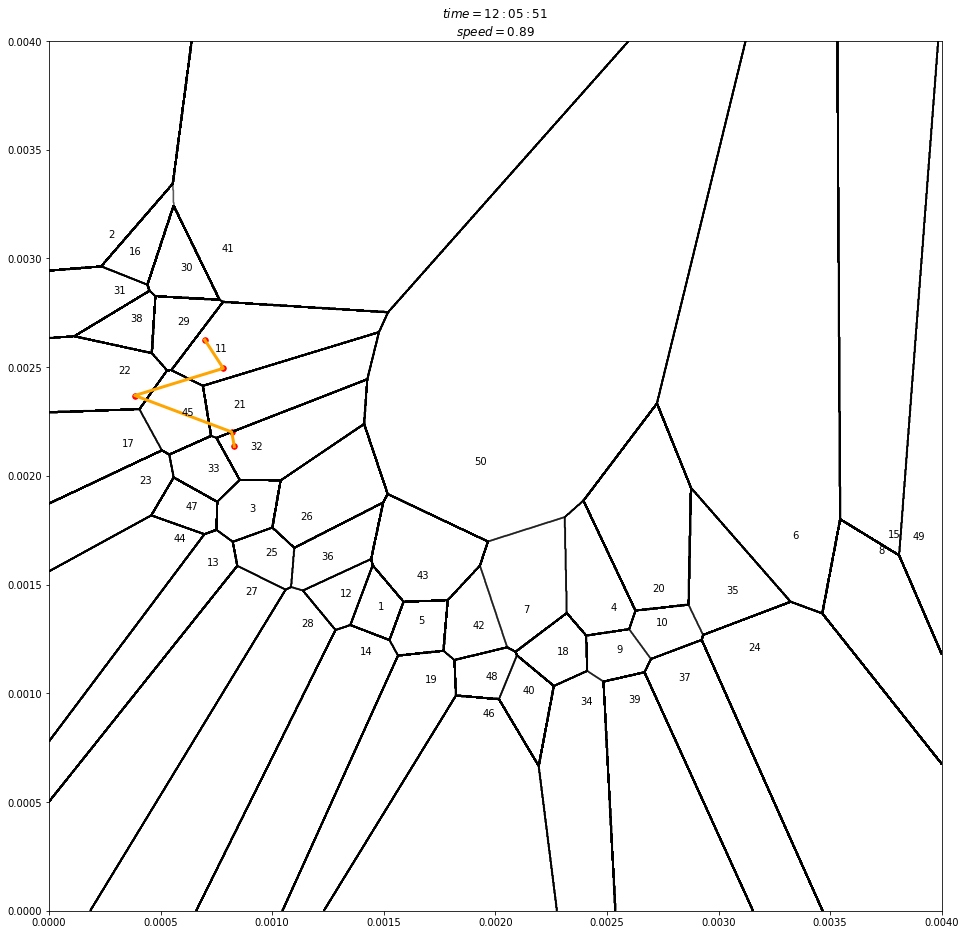

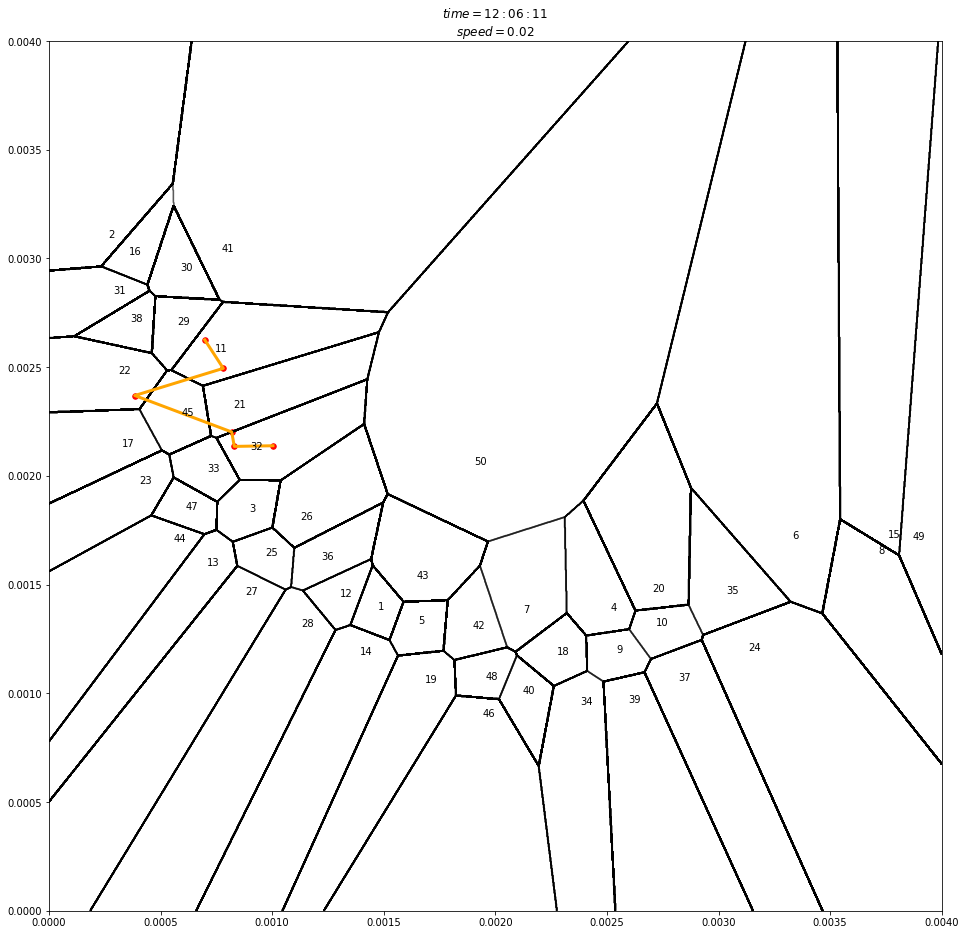

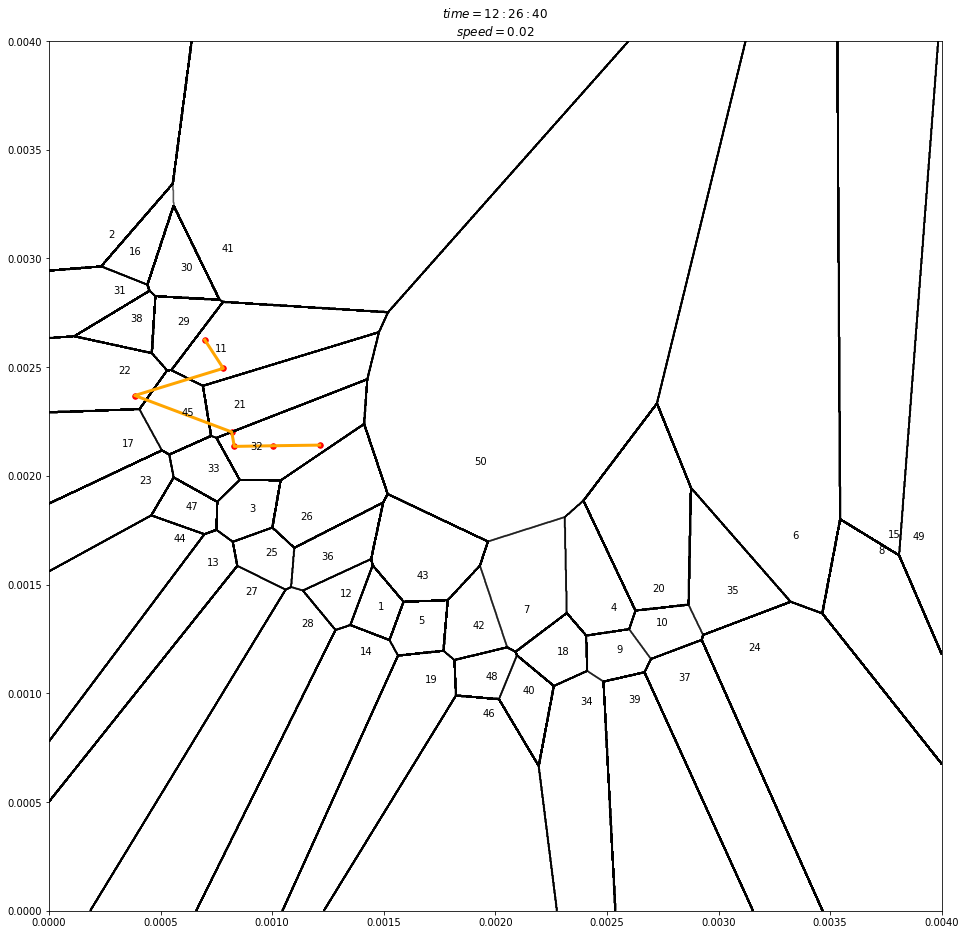

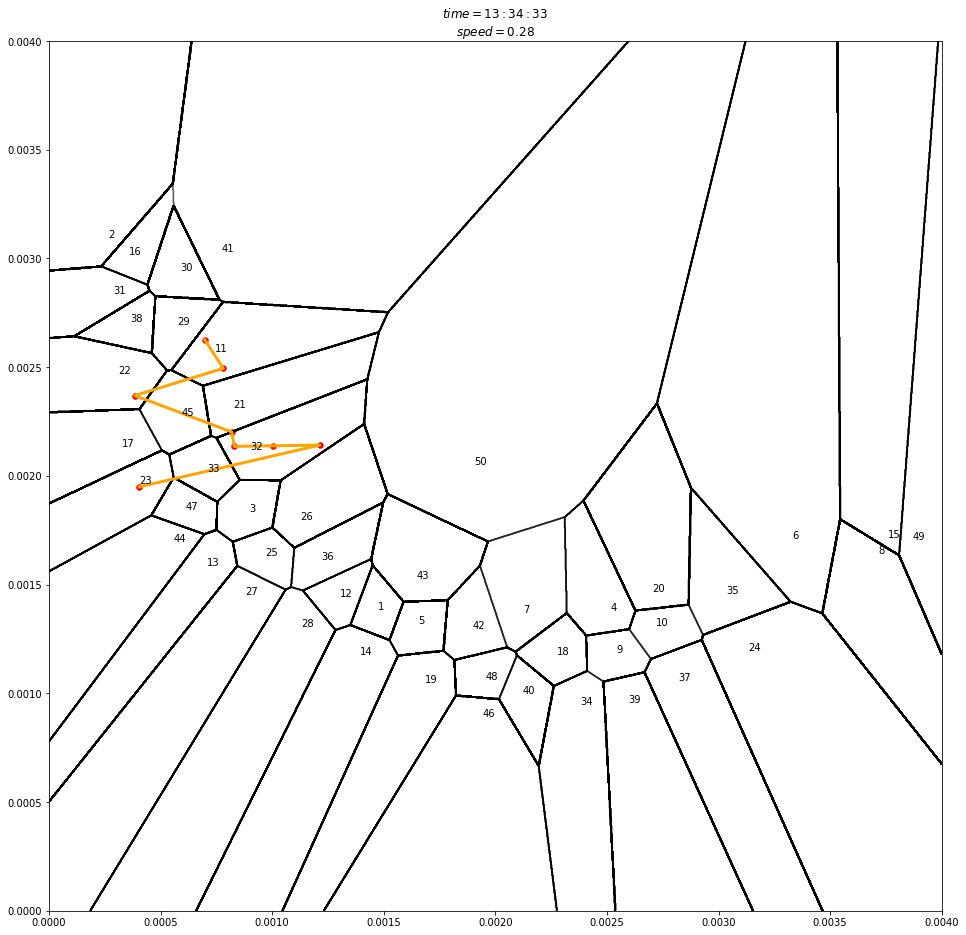

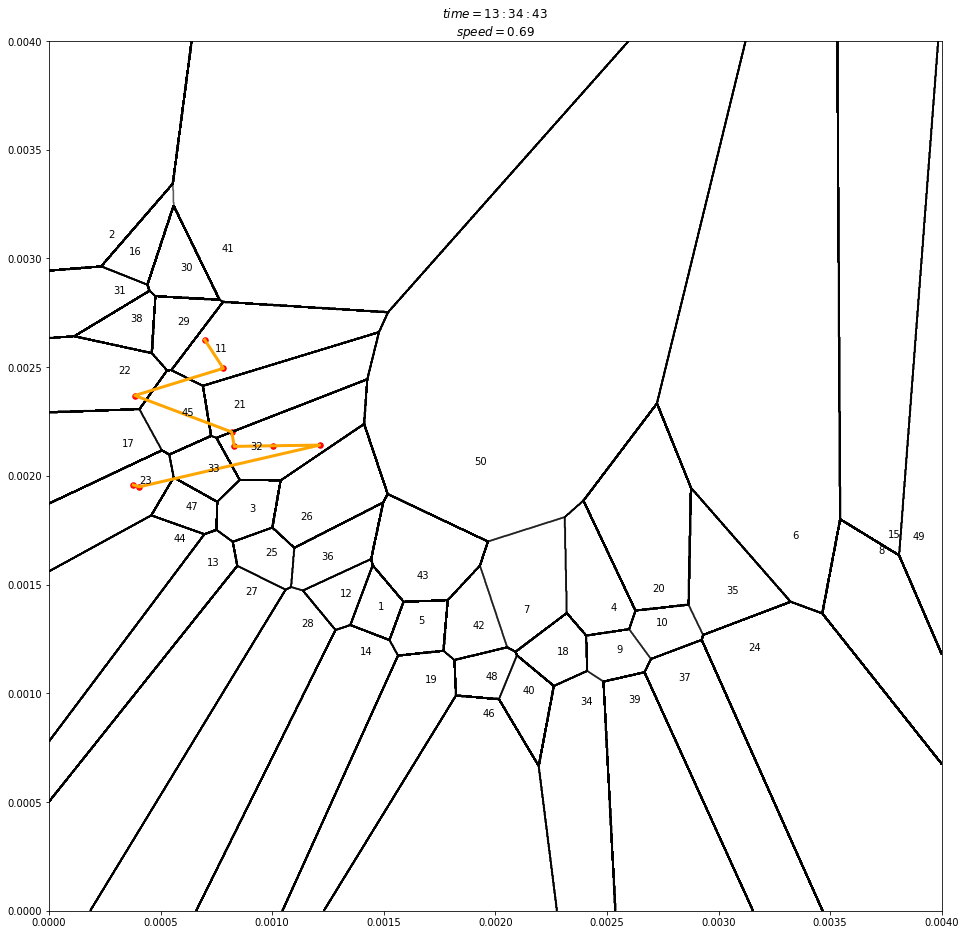

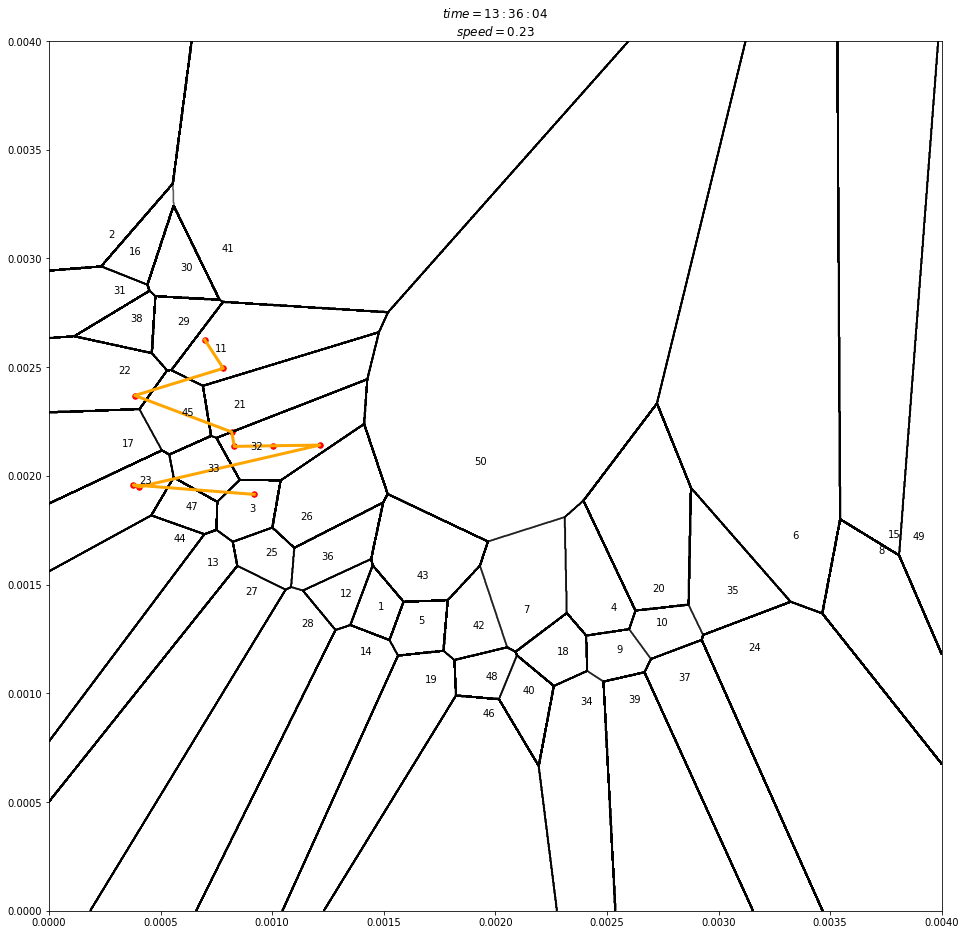

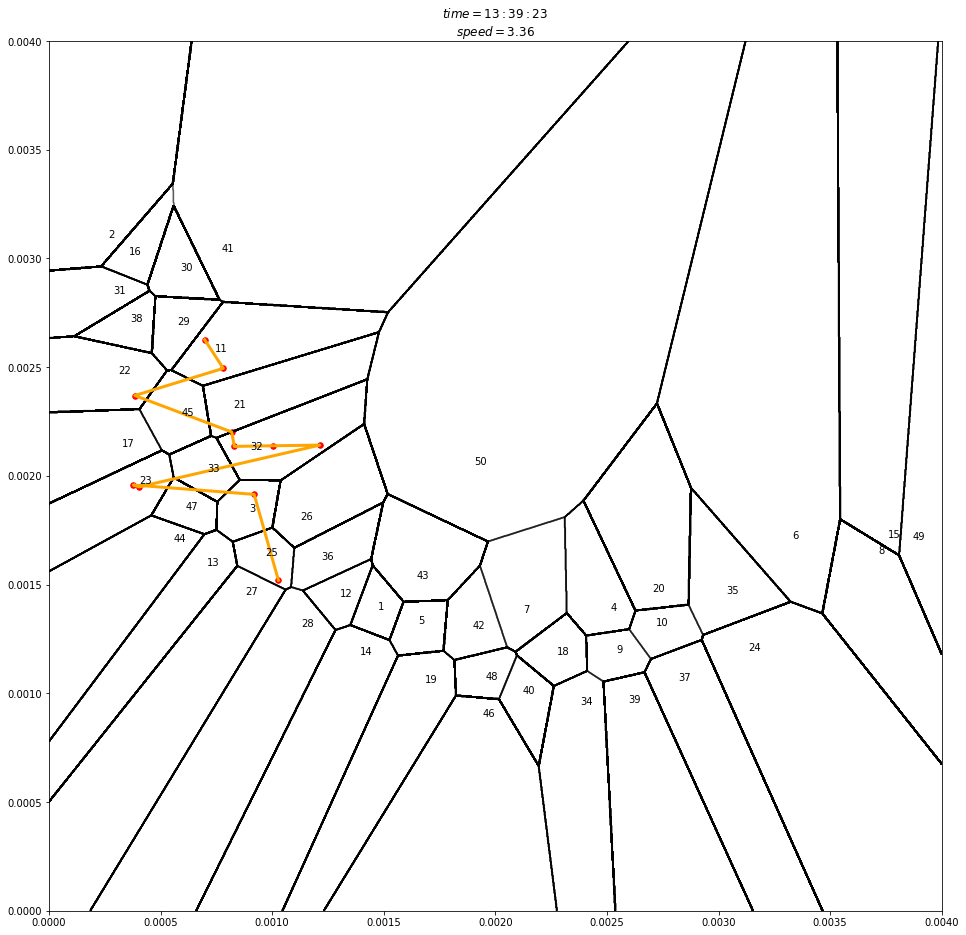

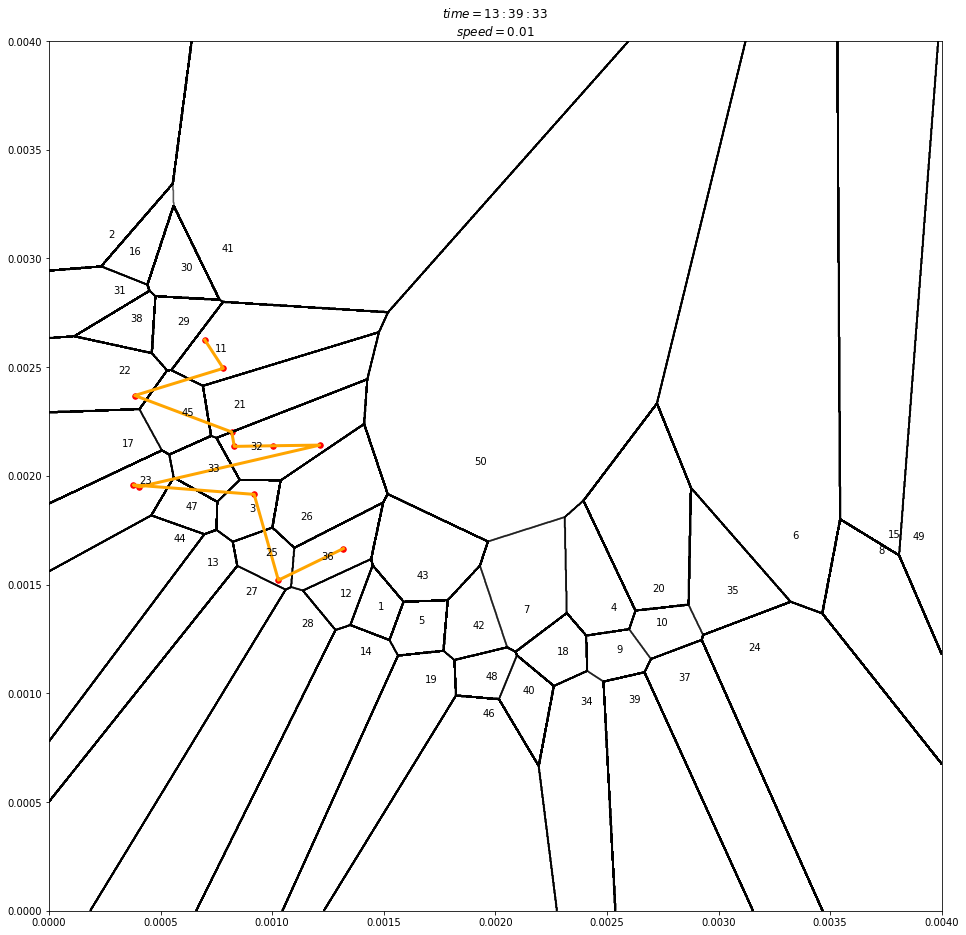

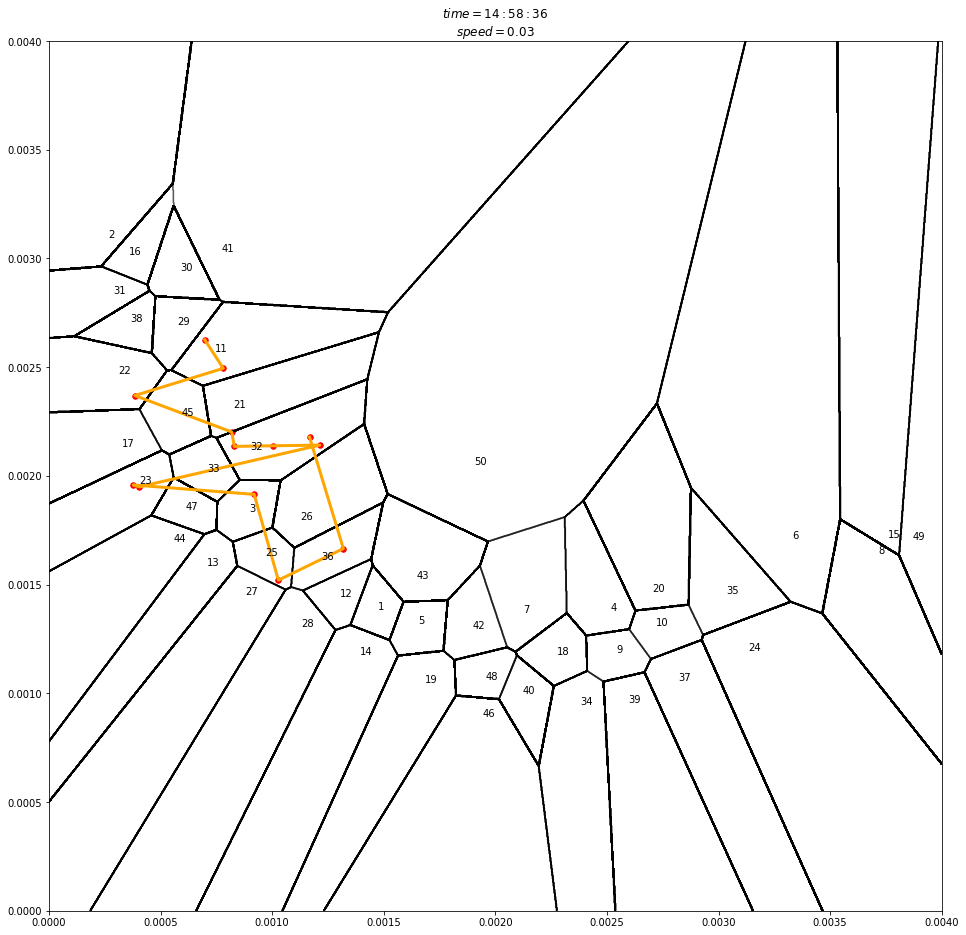

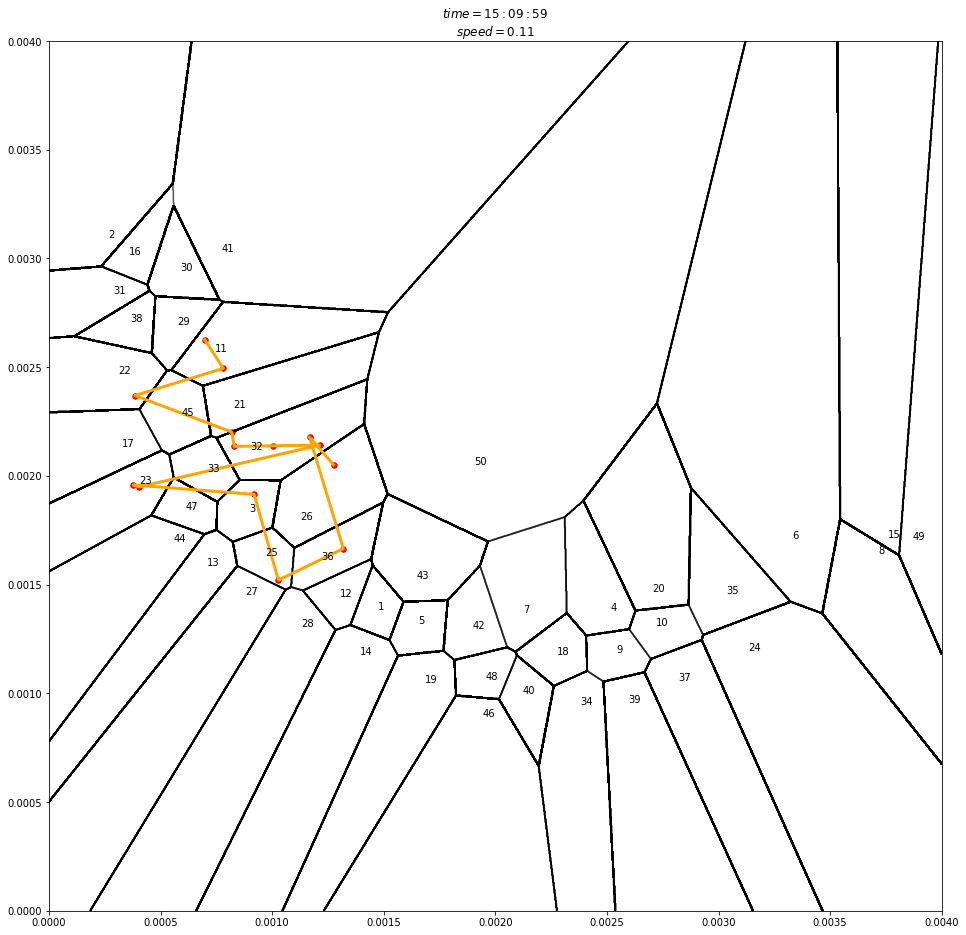

In [98]:
# import matplotlib.animation
# import imageio

# def plot_for_offset(i):
#     fig, ax = plt.subplots(figsize=(16, 16))
#     ax.contour(yy, xx, Z, 100, alpha=0.4, colors='black')
#     ax.set_xlim(x_min, x_max)
#     ax.set_ylim(y_min, y_max)
#     for j in range(len(center)):
#         ax.text(center[j][1], center[j][0], z_center[j], color='black')
# #     h = df_gb_path.total_minute_class[i]
# #     hour = h*5//60
# #     minute = h*5 - h*5//60 * 60
# #     ax.set_title('{} hour {} minute'.format(hour, minute))
#     time = df_gb_path.datetime[i].strftime("%H:%M:%S")
#     speed = df_gb_path.speed[i]
#     title = '\n'.join((
#     r'$time=%s$' % (time, ),
#     r'$speed=%.2f$' % (speed, )))
#     ax.set_title(title)
#     path_coord = np.array(df_gb_path.latlon_rev[:i+1])
#     ax.plot(path_coord[:,1],path_coord[:,0], color='orange', linewidth=3)
#     ax.scatter(path_coord[:,1],path_coord[:,0], color='red', s=30)
    
#     fig.canvas.draw()       # draw the canvas, cache the renderer
#     image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#     image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

#     return image
# kwargs_write = {'fps':1.0, 'quantizer':'nq'}
# imageio.mimsave('./sample.gif', [plot_for_offset(i) for i in range(0,14)], fps=1)

In [25]:
df_gb_clean = df_gb.drop(['time', 'latlon_dp', 'latlon','latlon_rev','datetime','hour','minute','total_minute','distance', 'time_diff'], axis=1)
df_gb_clean['speed'] = df_gb_clean.speed.map(lambda x: x+[0])
df_gb_clean.reset_index(drop=True, inplace=True)
df_gb_clean['next_cluster'] = df_gb_clean.cluster.map(lambda x: x[1:] + [0])

In [26]:
df_gb_final = pd.DataFrame.from_items([(index, zipped) for index, row in df_gb_clean.iterrows() for zipped in zip(*row)], orient='index', columns=df_gb_clean.columns)

/Users/haoanwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """Entry point for launching an IPython kernel.


In [27]:
df_gb_final.reset_index(inplace=True, drop=True)
df_gb_final.drop(df_gb_final[df_gb_final.next_cluster==0].index, axis=0, inplace=True)
df_gb_final.reset_index(inplace=True, drop=True)

df_gb_final = df_gb_final[df_gb_final.speed>0.1]

In [28]:
df_gb_final = df_gb_final.groupby(['total_minute_class','cluster','next_cluster']).agg(list)

df_gb_final['speed_len'] = df_gb_final.speed.map(len)
df_gb_final['avg'] = df_gb_final.speed.map(np.mean)

In [29]:
df_clean = df.drop(['id','time','latlon','latlon_dp','datetime','hour','minute','total_minute'], axis=1)

In [30]:
df_clean2 = df.drop(['latlon_rev','time','latlon','latlon_dp','datetime','hour','minute','total_minute'], axis=1)

In [31]:
# fig, ax = plt.subplots(figsize=(10, 10))

# plt.gca().set_axis_off()
# plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#             hspace = 0, wspace = 0)
# plt.margins(0,0)
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())
# ax.contour(yy, xx, Z, 100, alpha=0.4, colors='black')
# ax.set_axis_off()

# plt.savefig("frame.png", bbox_inches = 'tight', dpi=100,
#     pad_inches = 0)


In [32]:
df_clean_num = df_clean2.groupby(['total_minute_class','cluster']).agg(set)
df_clean_num['id'] = df_clean_num['id'].map(len)

In [33]:
df_threshold = pd.read_csv('tps2_level3/count/detail.csv')

In [34]:
df_threshold.set_index(['total_minute_class', 'cluster'], inplace=True, drop=True)

In [35]:
for i in range(288):
    for j in range(1,51):
        try:
            x =df_threshold.loc[(i,j),:]
        except:
            df_threshold.loc[(i,j),:] = 0

In [36]:
df_threshold = df_threshold.merge(df_clean_num, how='outer', left_index=True, right_index=True)
df_threshold.fillna(0, inplace=True)

In [37]:
df_threshold['crowd'] = df_threshold.apply(lambda x: (x.id > 30) and (x.id > x.threshold), axis=1)

<IPython.core.display.Javascript object>


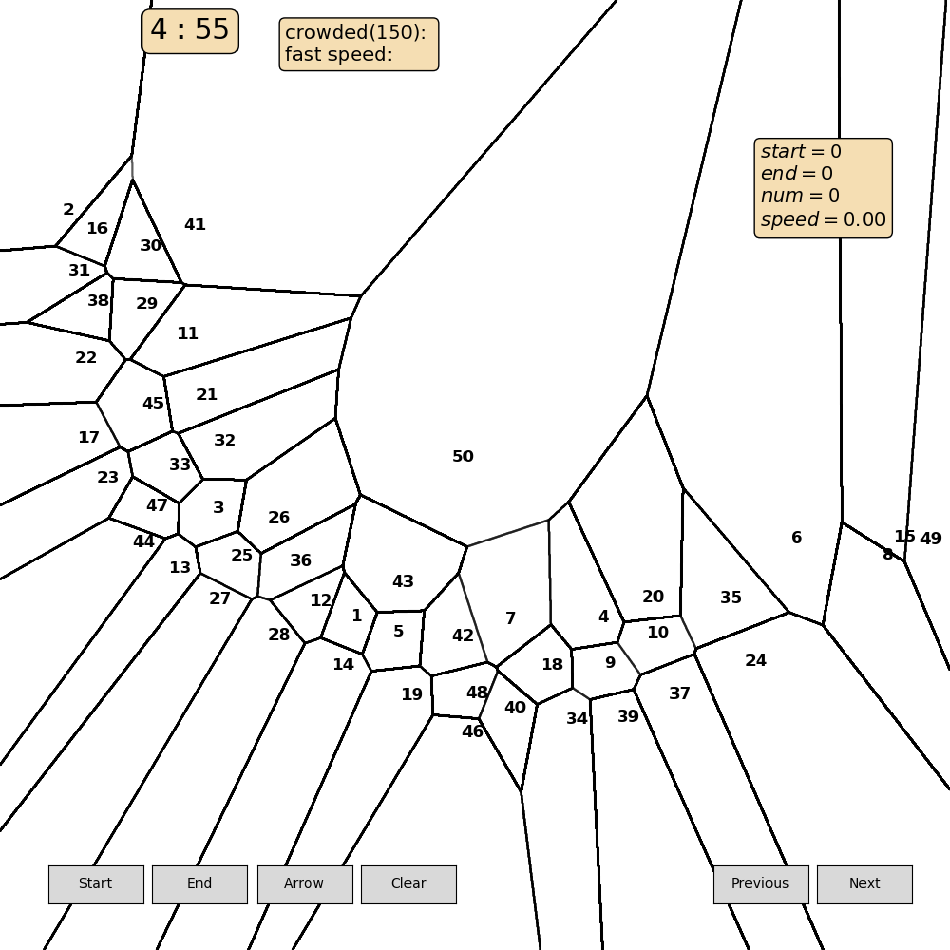

In [37]:
# %matplotlib notebook
# from matplotlib.widgets import Button
# CROWDED_THRESHOLD = 150
# fig, ax = plt.subplots(figsize=(9.5, 9.5))

# plt.gca().set_axis_off()
# plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0)
# plt.margins(0,0)
# ax.set_axis_off()
# img = plt.imread("frame.png")
# title_obj = ax.set_title('{} : {}'.format(0, 0), x=0.2, y=0.95, bbox=dict(boxstyle='round', facecolor='wheat'), fontsize=20)
# ax.imshow(img, extent=[0, 0.004, 0, 0.004])
# for i in range(len(center)):
#     ax.text(center[i][1], center[i][0], z_center[i], color='black', weight='semibold', fontsize=12)
# sc = ax.scatter([], [], c=[], cmap='autumn', s=5, alpha=0.4)
# empty_sc_os = plt.getp(sc, 'offsets')
# empty_sc_ar = plt.getp(sc, 'array')
# empty_textstr = '\n'.join((
#     r'$start=%s$' % (0, ),
#     r'$end=%s$' % (0, ),
#     r'$num=%s$' % (0, ),
#     r'$speed=%.2f$' % (0, )))
# info = ax.text(0.80, 0.85, empty_textstr, transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

# empty_alertstr = '\n'.join((
#     'crowded({}): '.format(CROWDED_THRESHOLD),
#     'fast speed: '
# ))
# alert = ax.text(0.30, 0.975, empty_alertstr, transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))


# d, = ax.plot([],[],'-',c='lime', linewidth=3)
# sp = ax.scatter([],[], marker = 'o', c='lime')
# ep = ax.scatter([],[], marker = 'o', c='lime')

# ind = 0

# class nextprev(object):
    
#     def next(self, event):
#         global ind
#         global dire
#         dire.outside_clear()
#         ind += 1
#         hour = ind*5//60
#         minute = ind*5 - ind*5//60 * 60
#         plt.setp(title_obj, text ='{} : {}'.format(hour, minute))
#         temp = df_clean[df_clean.total_minute_class == ind]
#         temp2 = df_clean_num.loc[ind].latlon_rev
#         crowded_list = temp2[temp2 > CROWDED_THRESHOLD].index.to_list()
#         self.text_update(crowded_list)
#         if temp.shape[0] != 0:
#             temp_coord = np.array(temp.latlon_rev.tolist())
#             plt.setp(sc, offsets = np.c_[temp_coord[:,1],temp_coord[:,0]], array = temp['cluster'].values)
#         else:
#             plt.setp(sc, offsets = empty_sc_os, array=empty_sc_ar)
    
            


#     def prev(self, event):
#         global ind
#         global dire
#         dire.outside_clear()
#         if ind > 0:
#             ind -= 1
#             hour = ind*5//60
#             minute = ind*5 - ind*5//60 * 60
#             plt.setp(title_obj, text = '{} : {}'.format(hour, minute))
#             temp = df_clean[df_clean.total_minute_class == ind]
#             temp2 = df_clean_num.loc[ind].latlon_rev
#             crowded_list = temp2[temp2 > CROWDED_THRESHOLD].index.to_list()
#             self.text_update(crowded_list)
#             if temp.shape[0] != 0:
#                 temp_coord = np.array(temp.latlon_rev.tolist())
#                 temp_coord = np.array(temp.latlon_rev.tolist())
#                 plt.setp(sc, offsets = np.c_[temp_coord[:,1],temp_coord[:,0]], array = temp['cluster'].values)
#             else:
#                 plt.setp(sc, offsets = empty_sc_os, array=empty_sc_ar)
#         else:
#             ind = 0
            
#     def text_update(self, l):
#         temp_alertstr = '\n'.join((
#             'crowded({}): {}'.format(CROWDED_THRESHOLD, l),
#             'fast speed: '
#         ))
#         plt.setp(alert, text = temp_alertstr)

# class direction(object):
#     start = [0.001,0.001]
#     end = [0.003,0.003]
#     class_start = 0
#     class_end = 0
#     cid_start = None
#     cid_end = None
#     a = None
#     num = 0
#     speed = 0
    
#     def start_point(self, event):
#         plt.setp(sp, offsets = np.c_[[], []])
#         self.class_start = 0
#         self.num = 0
#         self.speed = 0
#         self.text_update()
#         self.cid_start = fig.canvas.mpl_connect('button_press_event', self.onclick_start)
#         d.set_xdata([[], []])
#         d.set_ydata([[], []])
#         try:
#             self.a.remove()
#         except:
#             pass
        
#     def end_point(self, event):
#         plt.setp(ep, offsets = np.c_[[], []])
#         self.class_end = 0
#         self.num = 0
#         self.speed = 0
#         self.text_update()
#         self.cid_end = fig.canvas.mpl_connect('button_press_event', self.onclick_end)
#         d.set_xdata([[], []])
#         d.set_ydata([[], []])
#         try:
#             self.a.remove()
#         except:
#             pass
        
#     def onclick_start(self, event):
#         self.class_start = cluster_rank[kmeans.predict(np.c_[[event.ydata], [event.xdata]])[0]]
#         self.start[0], self.start[1] = center_dict[self.class_start][1], center_dict[self.class_start][0]
#         plt.setp(sp, offsets = np.c_[[self.start[0]], [self.start[1]]])
#         self.text_update()
#         fig.canvas.mpl_disconnect(self.cid_start)

#     def onclick_end(self, event):
#         self.class_end = cluster_rank[kmeans.predict(np.c_[[event.ydata], [event.xdata]])[0]]
#         self.end[0], self.end[1] = center_dict[self.class_end][1], center_dict[self.class_end][0]
#         plt.setp(ep, offsets = np.c_[[self.end[0]], [self.end[1]]])
#         self.text_update()
#         fig.canvas.mpl_disconnect(self.cid_end)
        
#     def onclick_arrow(self, event):
#         global ind
#         d.set_xdata([self.start[0], self.end[0]])
#         d.set_ydata([self.start[1], self.end[1]])
#         self.a = d.axes.annotate('',xytext=(self.start[0], self.start[1]),
#                                  xy=((self.end[0]+self.start[0])/2,(self.end[1]+self.start[1])/2),arrowprops=dict(arrowstyle="-|>",color='lime'), size=30)
#         temp_direction_df = df_gb_final.loc[ind,:]
#         info_series = temp_direction_df.loc[(self.class_start, self.class_end)]
#         self.num = info_series.speed_len
#         self.speed = info_series.avg
#         self.text_update()
        
#     def onclick_clear(self, event):
#         self.start[0], self.start[1]  = 0.001, 0.001
#         self.end[0], self.end[1] = 0.003, 0.003
#         d.set_xdata([[], []])
#         d.set_ydata([[], []])
#         plt.setp(sp, offsets = np.c_[[], []])
#         plt.setp(ep, offsets = np.c_[[], []])
#         self.class_start = 0
#         self.class_end = 0
#         self.num = 0
#         self.speed = 0
#         self.text_update()
#         try:
#             self.a.remove()
#         except:
#             pass
        
#     def outside_clear(self):
#         self.start[0], self.start[1]  = 0.001, 0.001
#         self.end[0], self.end[1] = 0.003, 0.003
#         d.set_xdata([[], []])
#         d.set_ydata([[], []])
#         plt.setp(sp, offsets = np.c_[[], []])
#         plt.setp(ep, offsets = np.c_[[], []])
#         self.class_start = 0
#         self.class_end = 0
#         self.num = 0
#         self.speed = 0
#         self.text_update()
#         try:
#             self.a.remove()
#         except:
#             pass
            
#     def text_update(self):
#         temp_textstr = '\n'.join((
#             r'$start=%s$' % (self.class_start, ),
#             r'$end=%s$' % (self.class_end, ),
#             r'$num=%s$' % (self.num, ),
#             r'$speed=%.2f$' % (self.speed, )))
#         plt.setp(info, text = temp_textstr)
        


# next_prev = nextprev()    
# axprev = plt.axes([0.75, 0.05, 0.1, 0.04])
# axnext = plt.axes([0.86, 0.05, 0.1, 0.04])
# bnext = Button(axnext, 'Next')
# bnext.on_clicked(next_prev.next)
# bprev = Button(axprev, 'Previous')
# bprev.on_clicked(next_prev.prev)

# dire = direction()
# axstart = plt.axes([0.05, 0.05, 0.1, 0.04])
# axend = plt.axes([0.16, 0.05, 0.1, 0.04])
# bstart = Button(axstart, 'Start')
# bstart.on_clicked(dire.start_point)

# bend = Button(axend, 'End')
# bend.on_clicked(dire.end_point)

# axarrow = plt.axes([0.27, 0.05, 0.1, 0.04])
# barrow = Button(axarrow, 'Arrow')
# barrow.on_clicked(dire.onclick_arrow)

# axclear = plt.axes([0.38, 0.05, 0.1, 0.04])
# bclear = Button(axclear, 'Clear')
# bclear.on_clicked(dire.onclick_clear)

# plt.show()

<IPython.core.display.Javascript object>


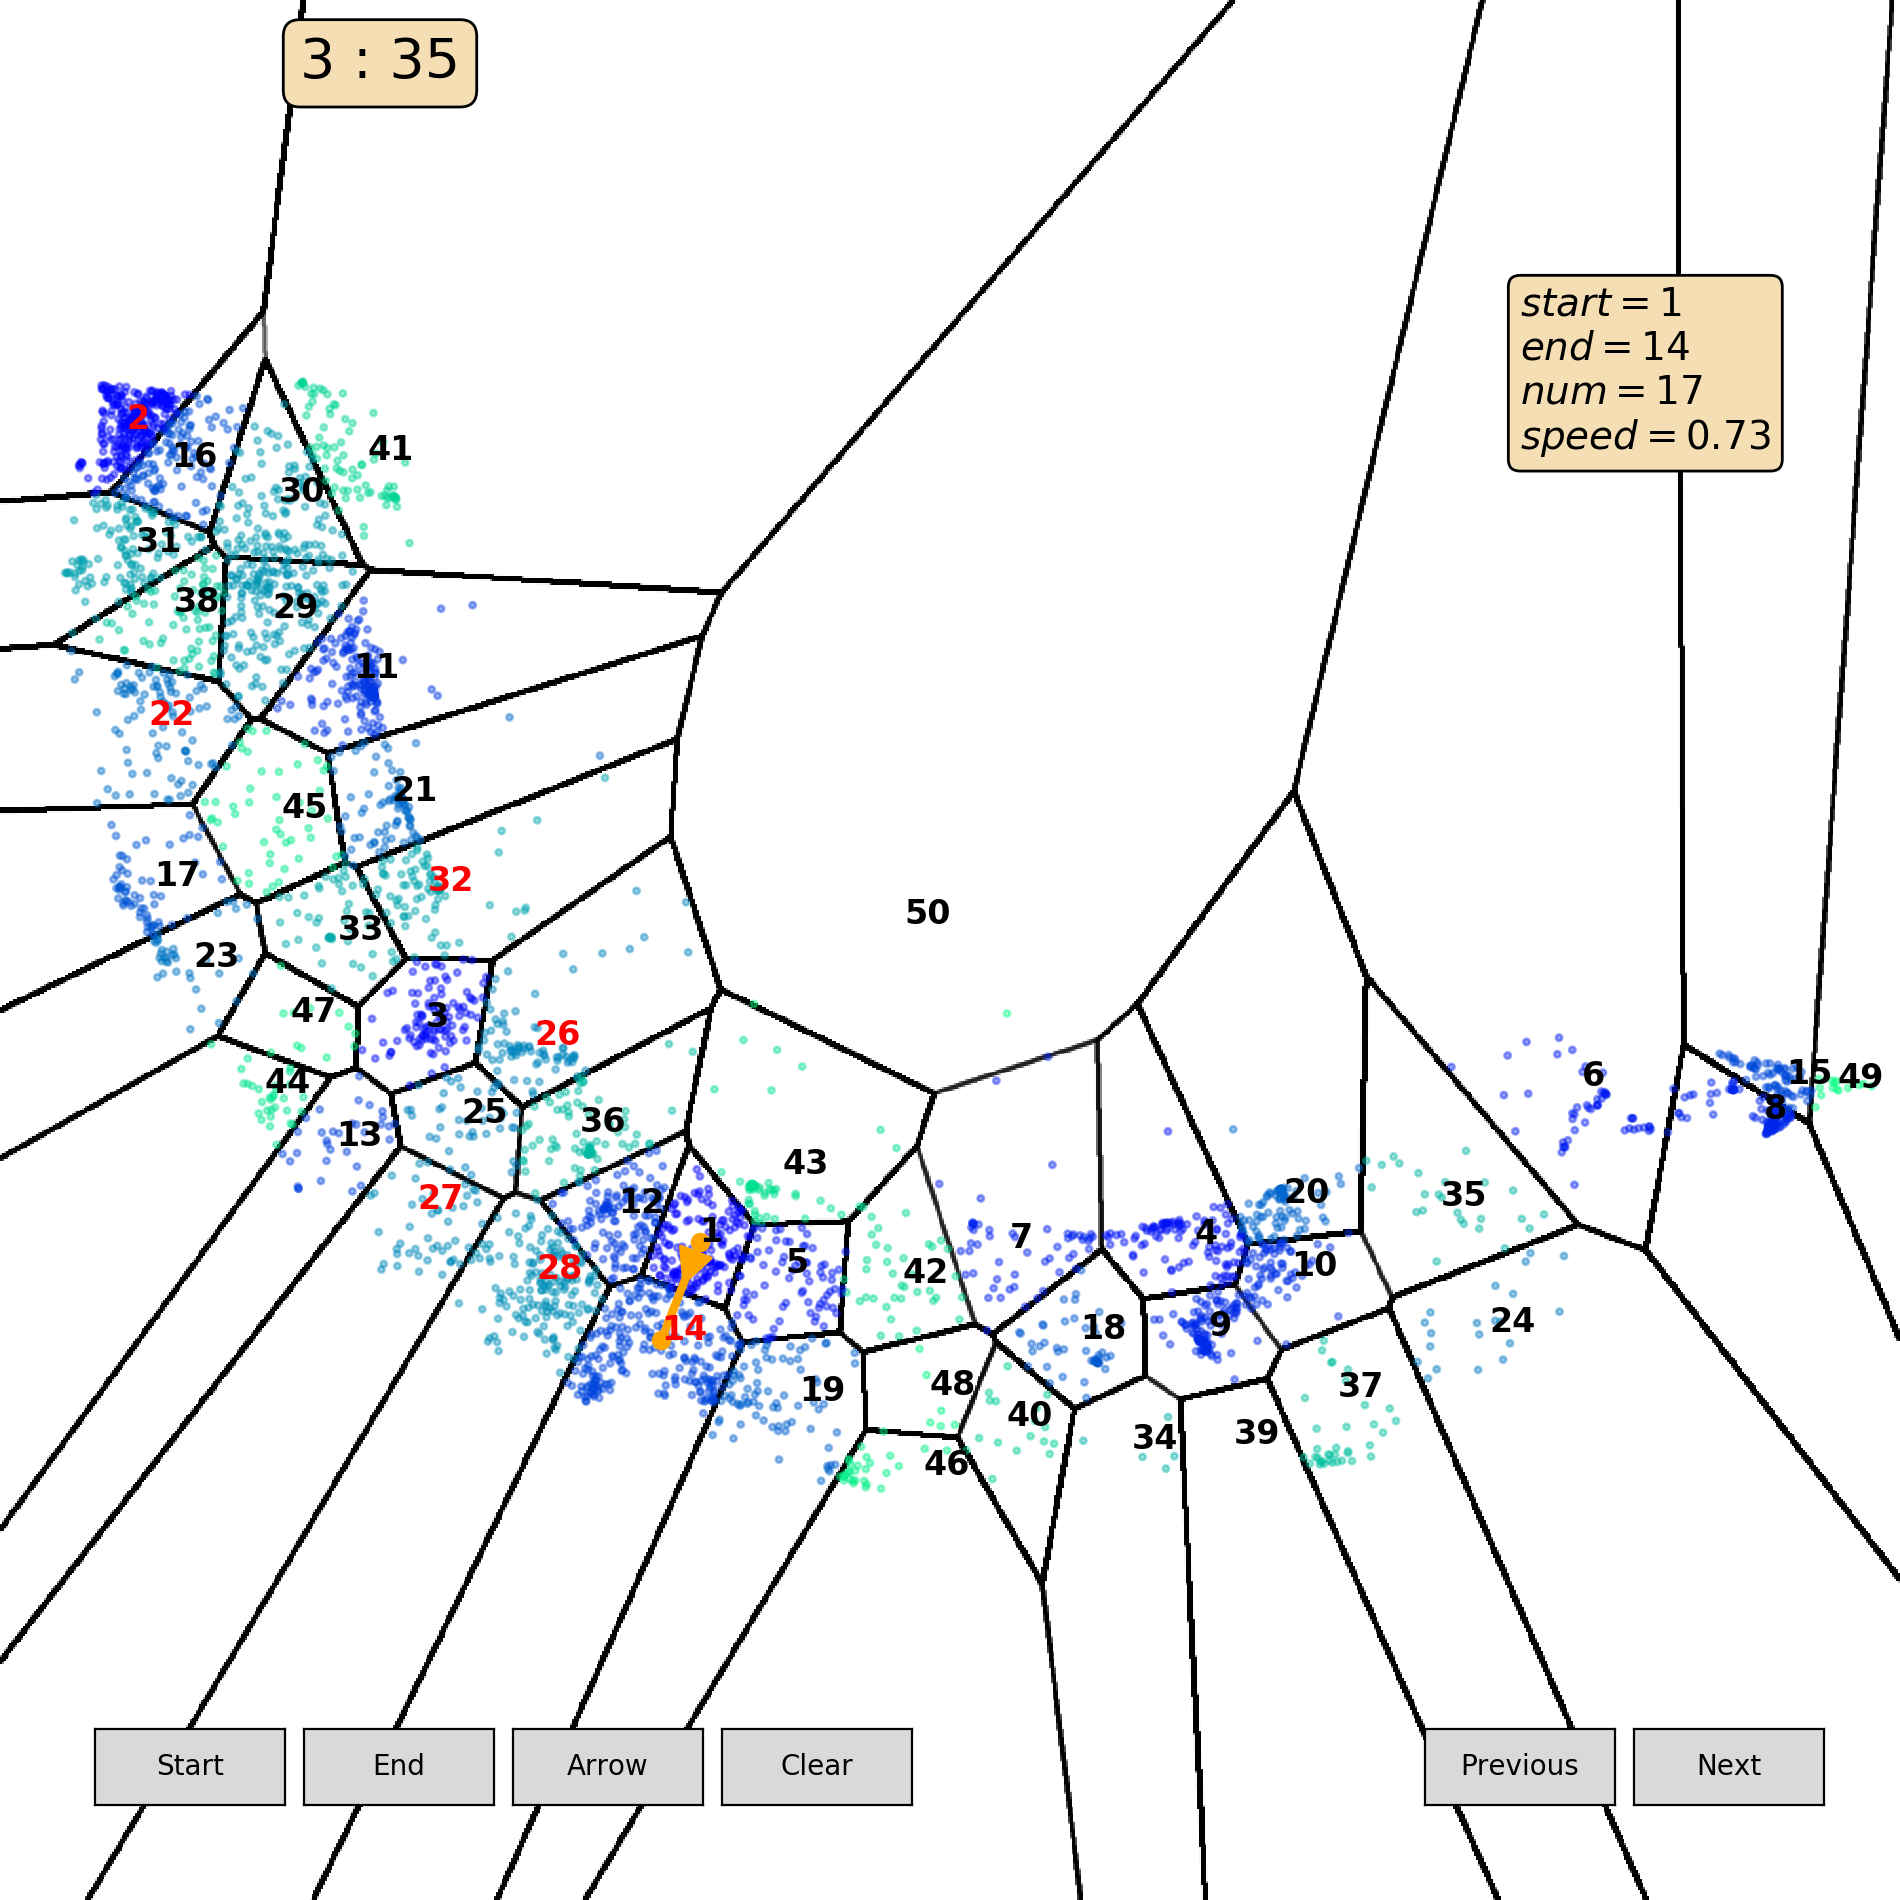

In [38]:
%matplotlib notebook
from matplotlib.widgets import Button
fig, ax = plt.subplots(figsize=(9.5, 9.5))

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0)
plt.margins(0,0)
ax.set_axis_off()
img = plt.imread("frame.png")
title_obj = ax.set_title('{} : {}'.format(0, 0), x=0.2, y=0.95, bbox=dict(boxstyle='round', facecolor='wheat'), fontsize=20)
ax.imshow(img, extent=[0, 0.004, 0, 0.004])
text_dc = {}
for i in range(len(center)):
    text_dc[z_center[i]] = ax.text(center[i][1], center[i][0], z_center[i], color='black', weight='semibold', fontsize=12)
sc = ax.scatter([], [], c=[], cmap='winter', s=5, alpha=0.4)
empty_sc_os = plt.getp(sc, 'offsets')
empty_sc_ar = plt.getp(sc, 'array')
empty_textstr = '\n'.join((
    r'$start=%s$' % (0, ),
    r'$end=%s$' % (0, ),
    r'$num=%s$' % (0, ),
    r'$speed=%.2f$' % (0, )))
info = ax.text(0.80, 0.85, empty_textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))



d, = ax.plot([],[],'-',c='orange', linewidth=3)
sp = ax.scatter([],[], marker = 'o', c='orange')
ep = ax.scatter([],[], marker = 'o', c='orange')

ind = 0

class nextprev(object):
    
    def next(self, event):
        global ind
        global dire
        dire.outside_clear()
        ind += 1
        hour = ind*5//60
        minute = ind*5 - ind*5//60 * 60
        plt.setp(title_obj, text ='{} : {}'.format(hour, minute))
        temp = df_clean[df_clean.total_minute_class == ind]
        temp2 = df_threshold.loc[ind].crowd
        crowded_list = temp2[temp2 ==True].index.to_list()
        for k in range(1,51):
            plt.setp(text_dc[k],color='black')
        for k in crowded_list:
            plt.setp(text_dc[k],color='red')
        if temp.shape[0] != 0:
            temp_coord = np.array(temp.latlon_rev.tolist())
            plt.setp(sc, offsets = np.c_[temp_coord[:,1],temp_coord[:,0]], array = temp['cluster'].values)
        else:
            plt.setp(sc, offsets = empty_sc_os, array=empty_sc_ar)
    
            


    def prev(self, event):
        global ind
        global dire
        dire.outside_clear()
        if ind > 0:
            ind -= 1
            hour = ind*5//60
            minute = ind*5 - ind*5//60 * 60
            plt.setp(title_obj, text = '{} : {}'.format(hour, minute))
            temp = df_clean[df_clean.total_minute_class == ind]
            temp2 = df_threshold.loc[ind].crowd
            crowded_list = temp2[temp2 ==True].index.to_list()
            for k in range(1,51):
                plt.setp(text_dc[k],color='black')
            for k in crowded_list:
                plt.setp(text_dc[k],color='red')
            if temp.shape[0] != 0:
                temp_coord = np.array(temp.latlon_rev.tolist())
                plt.setp(sc, offsets = np.c_[temp_coord[:,1],temp_coord[:,0]], array = temp['cluster'].values)
            else:
                plt.setp(sc, offsets = empty_sc_os, array=empty_sc_ar)
        else:
            ind = 0
            

class direction(object):
    start = [0.001,0.001]
    end = [0.003,0.003]
    class_start = 0
    class_end = 0
    cid_start = None
    cid_end = None
    a = None
    num = 0
    speed = 0
    
    def start_point(self, event):
        plt.setp(sp, offsets = np.c_[[], []])
        self.class_start = 0
        self.num = 0
        self.speed = 0
        self.text_update()
        self.cid_start = fig.canvas.mpl_connect('button_press_event', self.onclick_start)
        d.set_xdata([[], []])
        d.set_ydata([[], []])
        try:
            self.a.remove()
        except:
            pass
        
    def end_point(self, event):
        plt.setp(ep, offsets = np.c_[[], []])
        self.class_end = 0
        self.num = 0
        self.speed = 0
        self.text_update()
        self.cid_end = fig.canvas.mpl_connect('button_press_event', self.onclick_end)
        d.set_xdata([[], []])
        d.set_ydata([[], []])
        try:
            self.a.remove()
        except:
            pass
        
    def onclick_start(self, event):
        self.class_start = cluster_rank[kmeans.predict(np.c_[[event.ydata], [event.xdata]])[0]]
        self.start[0], self.start[1] = center_dict[self.class_start][1], center_dict[self.class_start][0]
        plt.setp(sp, offsets = np.c_[[self.start[0]], [self.start[1]]])
        self.text_update()
        fig.canvas.mpl_disconnect(self.cid_start)

    def onclick_end(self, event):
        self.class_end = cluster_rank[kmeans.predict(np.c_[[event.ydata], [event.xdata]])[0]]
        self.end[0], self.end[1] = center_dict[self.class_end][1], center_dict[self.class_end][0]
        plt.setp(ep, offsets = np.c_[[self.end[0]], [self.end[1]]])
        self.text_update()
        fig.canvas.mpl_disconnect(self.cid_end)
        
    def onclick_arrow(self, event):
        global ind
        d.set_xdata([self.start[0], self.end[0]])
        d.set_ydata([self.start[1], self.end[1]])
        self.a = d.axes.annotate('',xytext=(self.start[0], self.start[1]),
                                 xy=((self.end[0]+self.start[0])/2,(self.end[1]+self.start[1])/2),arrowprops=dict(arrowstyle="-|>",color='orange'), size=30)
        temp_direction_df = df_gb_final.loc[ind,:]
        info_series = temp_direction_df.loc[(self.class_start, self.class_end)]
        self.num = info_series.speed_len
        self.speed = info_series.avg
        self.text_update()
        
    def onclick_clear(self, event):
        self.start[0], self.start[1]  = 0.001, 0.001
        self.end[0], self.end[1] = 0.003, 0.003
        d.set_xdata([[], []])
        d.set_ydata([[], []])
        plt.setp(sp, offsets = np.c_[[], []])
        plt.setp(ep, offsets = np.c_[[], []])
        self.class_start = 0
        self.class_end = 0
        self.num = 0
        self.speed = 0
        self.text_update()
        try:
            self.a.remove()
        except:
            pass
        
    def outside_clear(self):
        self.start[0], self.start[1]  = 0.001, 0.001
        self.end[0], self.end[1] = 0.003, 0.003
        d.set_xdata([[], []])
        d.set_ydata([[], []])
        plt.setp(sp, offsets = np.c_[[], []])
        plt.setp(ep, offsets = np.c_[[], []])
        self.class_start = 0
        self.class_end = 0
        self.num = 0
        self.speed = 0
        self.text_update()
        try:
            self.a.remove()
        except:
            pass
            
    def text_update(self):
        temp_textstr = '\n'.join((
            r'$start=%s$' % (self.class_start, ),
            r'$end=%s$' % (self.class_end, ),
            r'$num=%s$' % (self.num, ),
            r'$speed=%.2f$' % (self.speed, )))
        plt.setp(info, text = temp_textstr)
        


next_prev = nextprev()    
axprev = plt.axes([0.75, 0.05, 0.1, 0.04])
axnext = plt.axes([0.86, 0.05, 0.1, 0.04])
bnext = Button(axnext, 'Next')
bnext.on_clicked(next_prev.next)
bprev = Button(axprev, 'Previous')
bprev.on_clicked(next_prev.prev)

dire = direction()
axstart = plt.axes([0.05, 0.05, 0.1, 0.04])
axend = plt.axes([0.16, 0.05, 0.1, 0.04])
bstart = Button(axstart, 'Start')
bstart.on_clicked(dire.start_point)

bend = Button(axend, 'End')
bend.on_clicked(dire.end_point)

axarrow = plt.axes([0.27, 0.05, 0.1, 0.04])
barrow = Button(axarrow, 'Arrow')
barrow.on_clicked(dire.onclick_arrow)

axclear = plt.axes([0.38, 0.05, 0.1, 0.04])
bclear = Button(axclear, 'Clear')
bclear.on_clicked(dire.onclick_clear)

plt.show()